# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

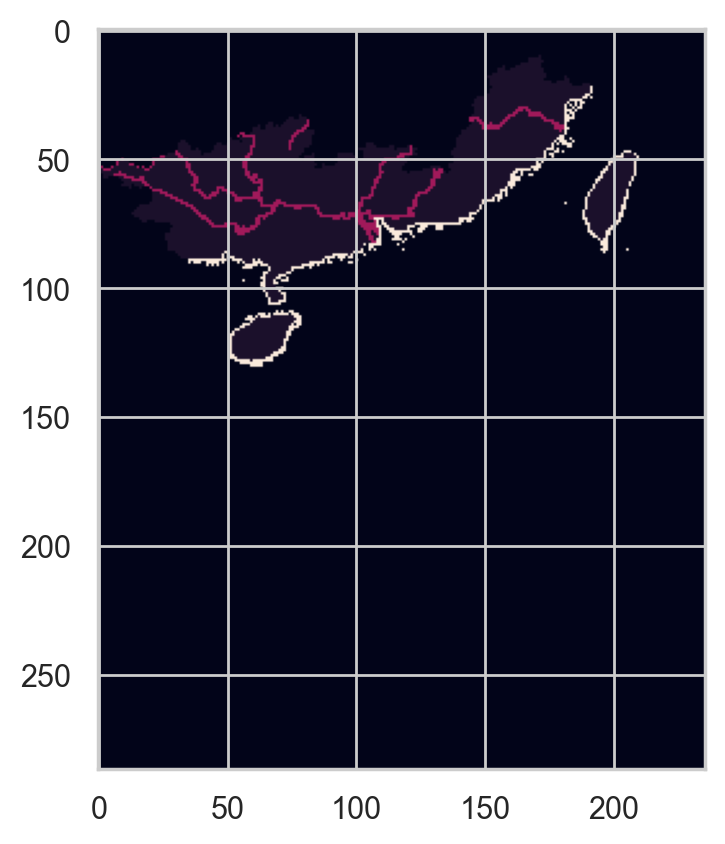

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

import rasterio

with rasterio.open(cfg.ds.lim_h) as dataset:
    arr = dataset.read(1)
    plt.imshow(arr)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [3]:
!pip show abses

Name: abses
Version: 0.8.5
Summary: ABSESpy makes it easier to build artificial Social-ecological systems with real GeoSpatial datasets and fully incorporate human behaviour.
Home-page: 
Author: Shuang Song
Author-email: songshgeo@gmail.com
License: Apache 2.0 License
Location: /Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages
Requires: fiona, fontawesome, geocube, geopandas, hydra-core, icons, loguru, mesa, mesa-geo, netcdf4, numpy, pendulum, rioxarray, seaborn, solara, typing-extensions, urllib3, xarray
Required-by: abses_sce, sc-20230710-sce


In [4]:
# 从这个路径加载模型
from src.core import Model
from src.api import Env

model = Model(parameters=cfg, nature_class=Env)
model.params.save_plots = False
model.nature.setup()

2025-10-20 15:13:49.918 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/abses/space/nature.py:85: UserWarning: Converting PatchModule from crs EPSG:4326 to the crs of Env - EPSG:4326. Please check your crs settings if this is unintended, or set `GeoSpace.warn_crs_conversion` to `False` to suppress this warning message.
  self.add_layer(module)
2025-10-20 15:13:50.145 | DEBUG    | abses.agents.container:new:286 - <Handling [1]Agents for Model> created 1 Hunter.
2025-10-20 15:13:50.146 | DEBUG    | abses.agents.container:new:286 - <Handling [1]Agents for Model> created 1 Hunter.
2025-10-20 15:13:50.147 | DEBUG    | abses.agents.container:new:286 - <Handling [1]Agents for Model> created 1 Hunter.
2025-10-20 15:13:50.148 | DEBUG    | abses.agents.container:new:286 - <Handling [1]Agents for Model> created 1 Hunter.
2025-10-20 15:13:50.148 | DEBUG    | abses.agents.container:n

农民可以停留的可耕种土地有3074，分布如下图：


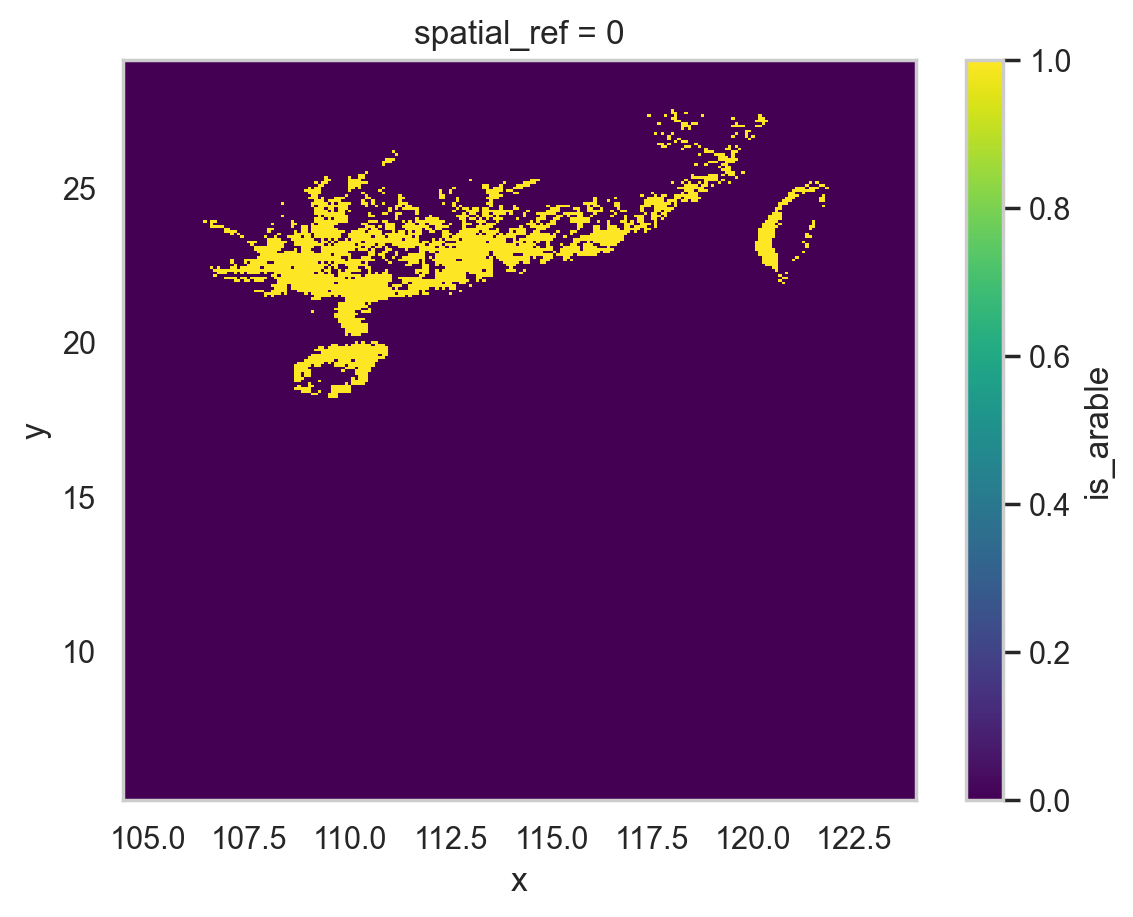

In [5]:
arable_land = model.nature.get_xarray("is_arable")
print(f"农民可以停留的可耕种土地有{arable_land.to_numpy().sum()}，分布如下图：")
arable_land.plot()

水稻农民可以停留的可耕种土地有924，分布如下图：


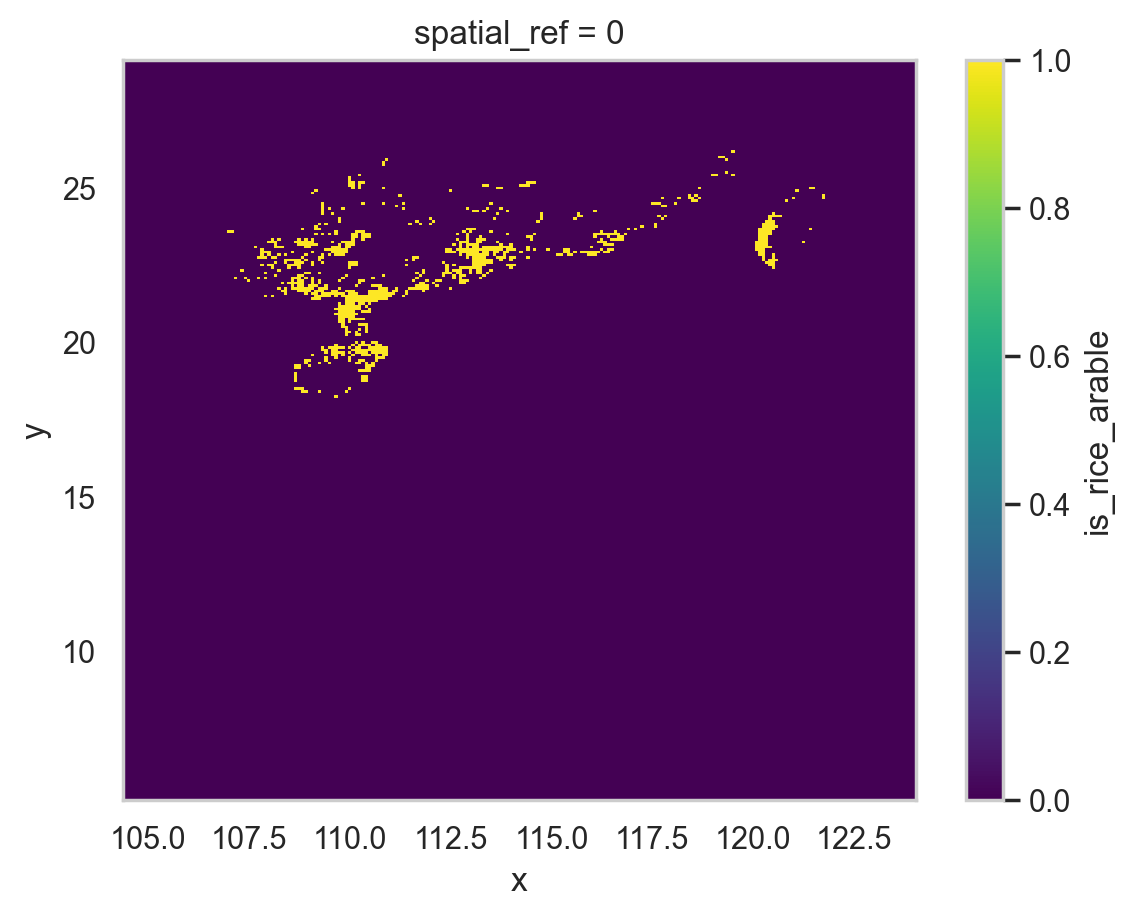

In [6]:
rice_arable = model.nature.get_xarray("is_rice_arable")
print(f"水稻农民可以停留的可耕种土地有{rice_arable.to_numpy().sum()}，分布如下图：")
rice_arable.plot()

增加了初始的 Hunters，随机生成在地图上

In [7]:
model.nature.dem.attributes

{'dem_suitable',
 'elevation',
 'farmers',
 'hunters',
 'is_arable',
 'is_only_arable',
 'is_rice_arable',
 'is_water',
 'lim_h',
 'rice_farmers',
 'slope',
 'slope_suitable'}

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Rice Farmers', ylabel='y'>)

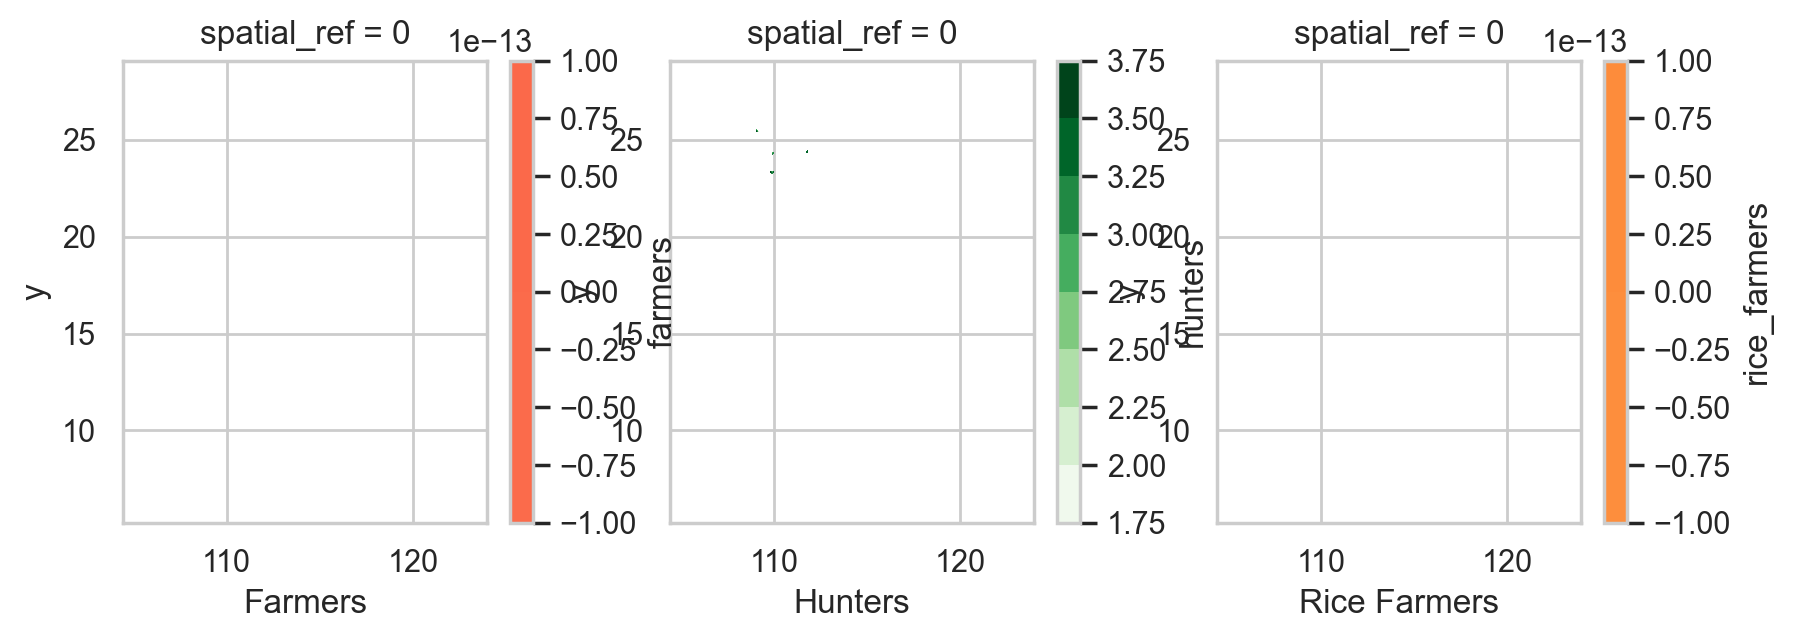

In [8]:
model.plot.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

2025-10-20 15:13:52.624 | DEBUG    | abses.agents.container:new:286 - <Handling [387]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.632 | DEBUG    | abses.agents.container:new:286 - <Handling [387]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.641 | DEBUG    | abses.agents.container:new:286 - <Handling [387]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.643 | DEBUG    | abses.agents.container:new:286 - <Handling [387]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.663 | DEBUG    | abses.agents.container:new:286 - <Handling [387]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.668 | DEBUG    | abses.agents.container:new:286 - <Handling [387]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.689 | DEBUG    | abses.agents.container:new:286 - <Handling [387]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.715 | DEBUG    | abses.agents.container:new:286 - <Handling [386]Agents for Model> created 1 Hunter.
2025-10-20 15:13:52.807 | DEBUG 

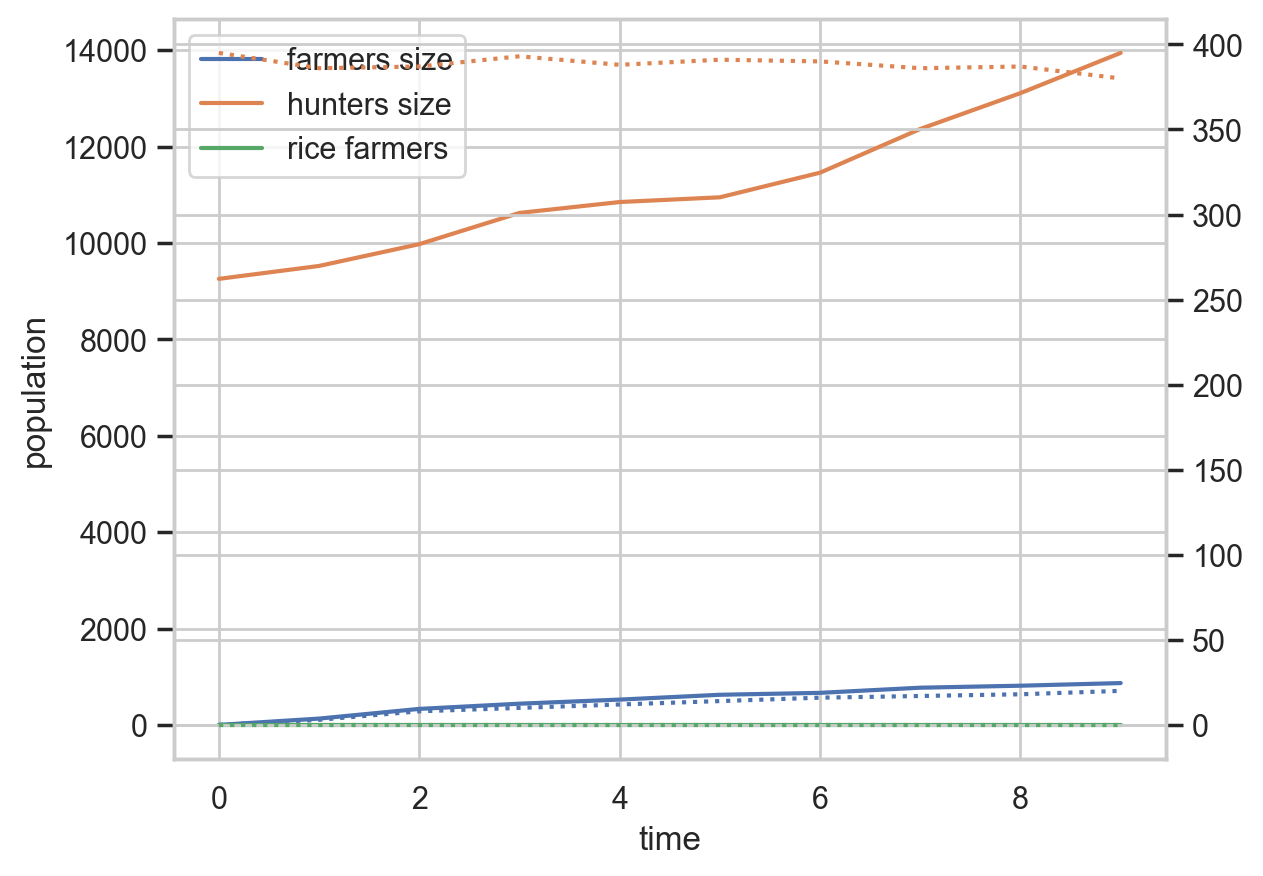

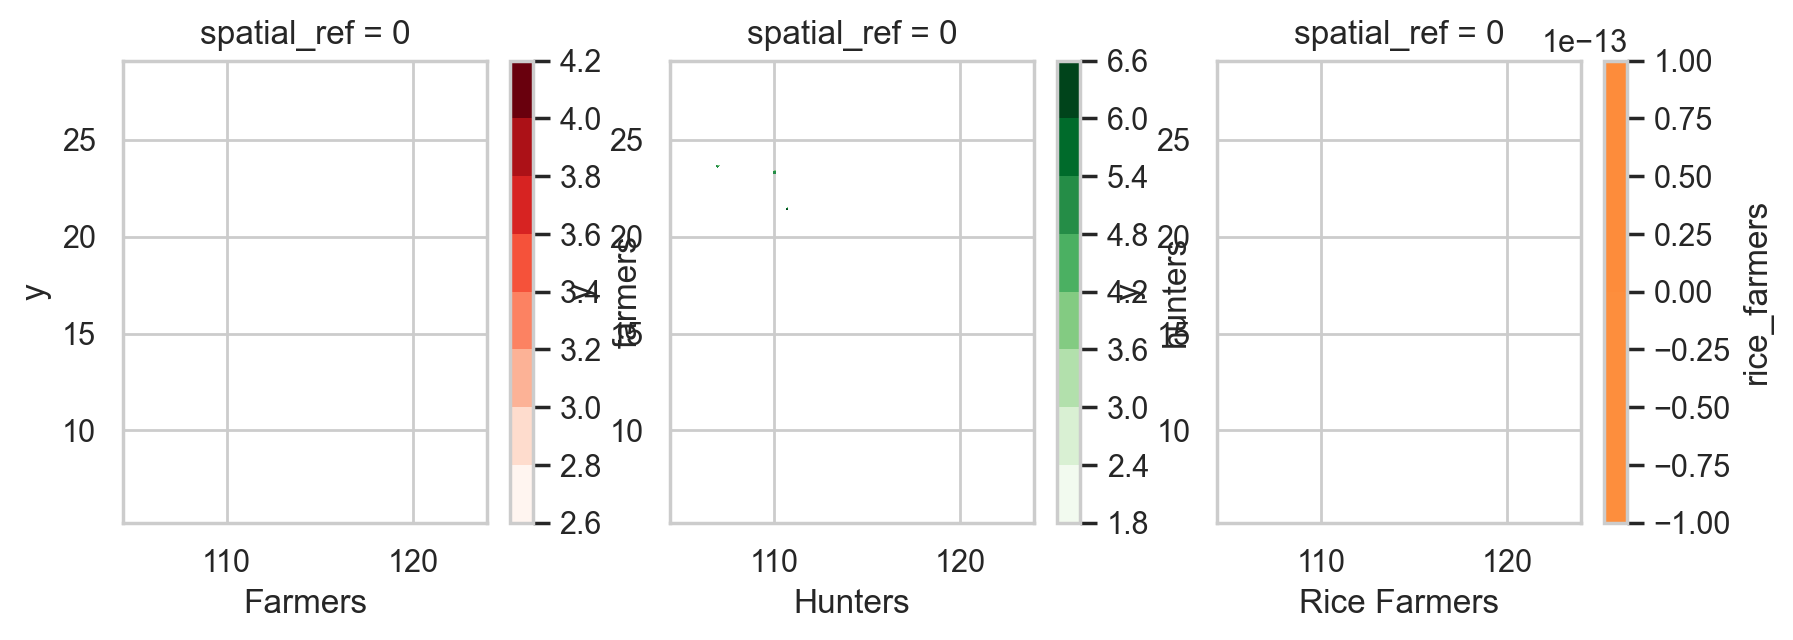

In [9]:
model.run_model(steps=200)

In [23]:
from src.api import Hunter

model.nature.dem.random.choice()._count(Hunter)

0.0

In [28]:
for agent in model.nature.dem.agents[:5]:
    cell = agent.at
    cell

<Cell at PatchModule[(14, 166)]>

<Cell at PatchModule[(15, 163)]>

<Cell at PatchModule[(15, 170)]>

<Cell at PatchModule[(16, 161)]>

<Cell at PatchModule[(16, 164)]>

In [31]:
cell.agents.select(agent_type=Hunter).array("size").sum()

20.0

In [32]:
cell._count(Hunter)

20.0

In [33]:
cell.hunters

20.0

展示主体的信息

In [10]:
agent = model.actors.random.choice()
agent.report()

unique_id          322
breed           Hunter
size              24.0
position     (62, 204)
dtype: object

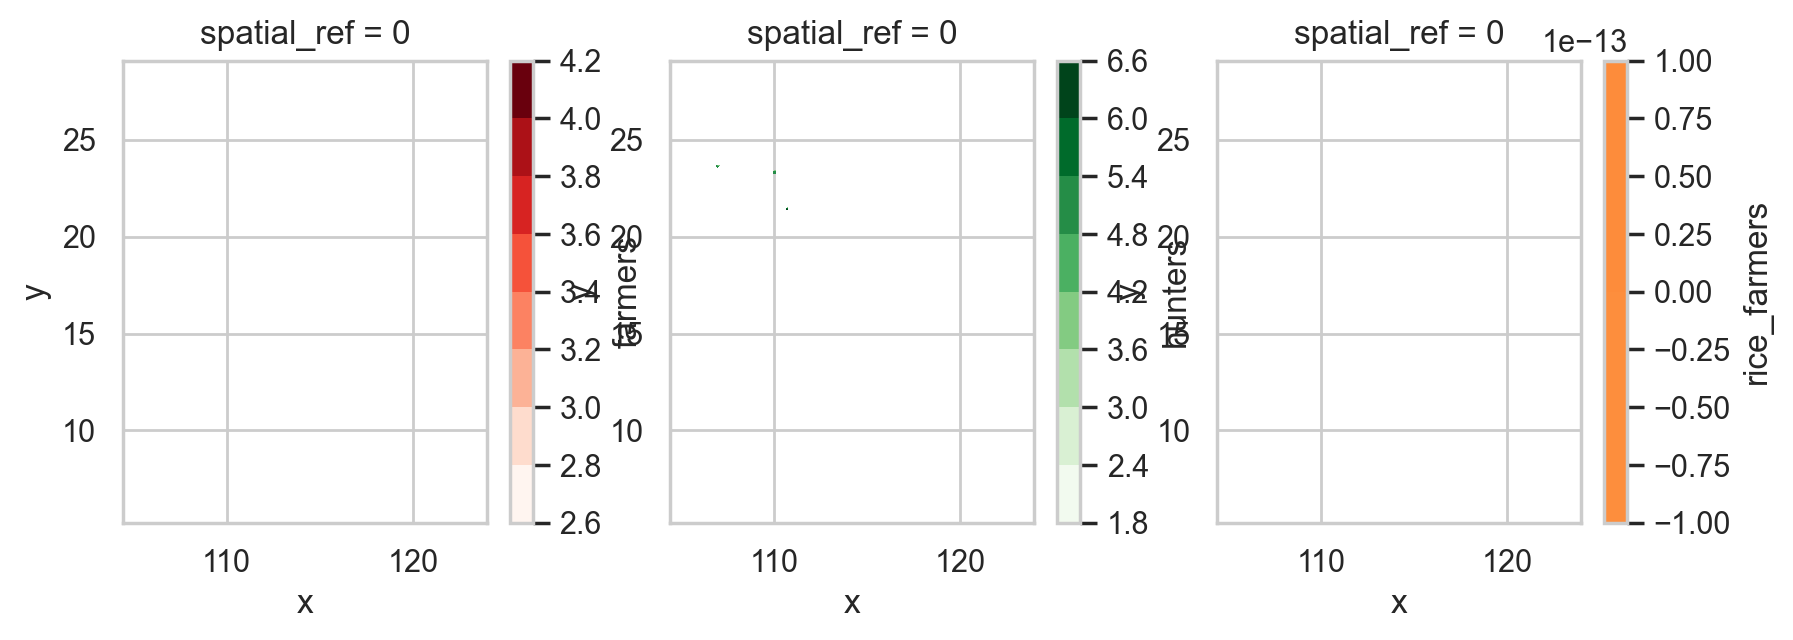

In [11]:
import xarray as xr


def log(xda_: xr.DataArray):
    return xr.apply_ufunc(np.log, xda_.where(xda_ != 0))


_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
mask = model.nature.get_xarray("elevation") >= 0
farmers = model.nature.get_xarray("farmers").where(mask)
hunters = model.nature.get_xarray("hunters").where(mask)
rice = model.nature.get_xarray("rice_farmers").where(mask)
# Calculate logarithmically, without warnings
log(farmers).plot.contourf(ax=ax1, cmap="Reds")
log(hunters).plot.contourf(ax=ax2, cmap="Greens")
log(rice).plot.contourf(ax=ax3, cmap="Oranges")

(<Axes: xlabel='Population'>, <Axes: xlabel='Groups'>)

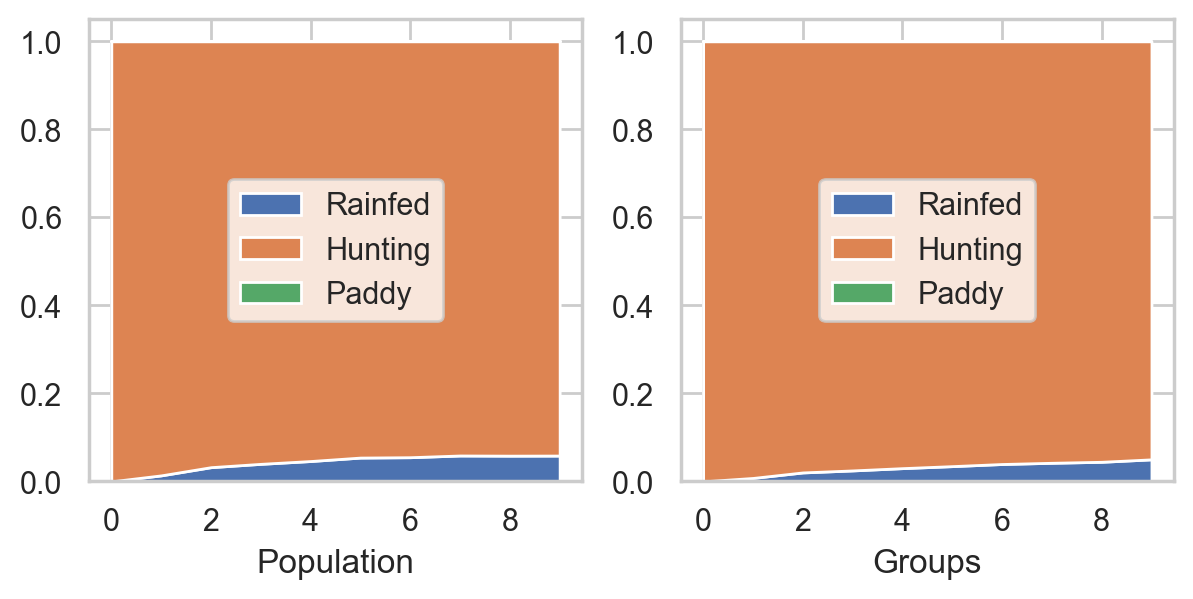

In [34]:
model.plot.stack_dynamic()

In [ ]:
from src.core import MyExperiment

exp = MyExperiment(Model, nature_cls=Env)
exp.batch_run(
    cfg=cfg, repeats=10, parallels=5, overrides={"farmer.growth_rate": [0.1, 0.2, 0.3]}
)

In [ ]:
exp.plot_agg_dynamic("farmers", "num")

In [ ]:
data = exp.get_model_vars_dataframe()
data.head()

In [ ]:
exp.summary()

In [ ]:
data.groupby(["job_id", "tick"])